# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=35,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-22-21/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5234 | MulticlassF1Score=0.0764
Batch-30 : CrossEntropyLoss=2.4601 | MulticlassF1Score=0.1696
Batch-45 : CrossEntropyLoss=2.4214 | MulticlassF1Score=0.2810
Batch-60 : CrossEntropyLoss=2.3869 | MulticlassF1Score=0.3697
Batch-75 : CrossEntropyLoss=2.3516 | MulticlassF1Score=0.4257
Batch-90 : CrossEntropyLoss=2.3496 | MulticlassF1Score=0.4657
Batch-105: CrossEntropyLoss=2.3576 | MulticlassF1Score=0.4940
Batch-120: CrossEntropyLoss=2.3522 | MulticlassF1Score=0.5144
Batch-135: CrossEntropyLoss=2.3582 | MulticlassF1Score=0.5321
Batch-150: CrossEntropyLoss=2.3444 | MulticlassF1Score=0.5457
Batch-165: CrossEntropyLoss=2.3707 | MulticlassF1Score=0.5573
Batch-180: CrossEntropyLoss=2.3365 | MulticlassF1Score=0.5677
Batch-195: CrossEntropyLoss=2.3315 | MulticlassF1Score=0.5758
Batch-210: CrossEntropyLoss=2.3338 | MulticlassF1Score=0.5856
Batch-225: CrossEntropyLoss=2.3266 | MulticlassF1Score=0.5954
Batch-226: CrossEntropyLoss=2.3306 | MulticlassF1Score=0.5958

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7261
Batch-30 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7318
Batch-45 : CrossEntropyLoss=2.3498 | MulticlassF1Score=0.7338
Batch-60 : CrossEntropyLoss=2.3367 | MulticlassF1Score=0.7351
Batch-63 : CrossEntropyLoss=2.3303 | MulticlassF1Score=0.7349

Training   : Mean CrossEntropyLoss = 2.3845 | Mean MulticlassF1Score = 0.4367
Validation : Mean CrossEntropyLoss = 2.3308 | Mean MulticlassF1Score = 0.7297

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3335 | MulticlassF1Score=0.7463
Batch-30 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7656
Batch-45 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7742
Batch-60 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7778
Batch-75 : CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7807
Batch-90 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.7817
Batch-105: CrossEntropyLoss=2.3243 | MulticlassF1Score=0.7824
Batch-120: CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7824
Batch-135: CrossEntropyLoss=2.3263 | MulticlassF1Score=0.7833
Batch-150: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7833
Batch-165: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7838
Batch-180: CrossEntropyLoss=2.3230 | MulticlassF1Score=0.7842
Batch-195: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7852
Batch-210: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7855
Batch-225: CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7856
Batch-226: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7856

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3187 | MulticlassF1Score=0.7905
Batch-30 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7915
Batch-45 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7900
Batch-60 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7889
Batch-63 : CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7891

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3152 | Mean MulticlassF1Score = 0.7771
Validation : Mean CrossEntropyLoss = 2.3131 | Mean MulticlassF1Score = 0.7914

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.7976
Batch-30 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7971
Batch-45 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7989
Batch-60 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7983
Batch-75 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7980
Batch-90 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.7982
Batch-105: CrossEntropyLoss=2.3141 | MulticlassF1Score=0.7977
Batch-120: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.7980
Batch-135: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7983
Batch-150: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7991
Batch-165: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7999
Batch-180: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8004
Batch-195: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8015
Batch-210: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8013
Batch-225: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8014
Batch-226: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8015

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8094
Batch-30 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8063
Batch-45 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8033
Batch-60 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8019
Batch-63 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8024

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3096 | Mean MulticlassF1Score = 0.7990
Validation : Mean CrossEntropyLoss = 2.3088 | Mean MulticlassF1Score = 0.8049

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8031
Batch-30 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8099
Batch-45 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.8078
Batch-60 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8078
Batch-75 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8094
Batch-90 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8093
Batch-105: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8100
Batch-120: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8105
Batch-135: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8107
Batch-150: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8110
Batch-165: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8111
Batch-180: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8112
Batch-195: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8110
Batch-210: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8107
Batch-225: CrossEntropyLoss=2.3145 | MulticlassF1Score=0.8106
Batch-226: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8106

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8047
Batch-30 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.8064
Batch-45 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.8049
Batch-60 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8047
Batch-63 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8043

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3065 | Mean MulticlassF1Score = 0.8095
Validation : Mean CrossEntropyLoss = 2.3080 | Mean MulticlassF1Score = 0.8049

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8108
Batch-30 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8140
Batch-45 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8157
Batch-60 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.8176
Batch-75 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8186
Batch-90 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8215
Batch-105: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8220
Batch-120: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8233
Batch-135: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8245
Batch-150: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8250
Batch-165: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8254
Batch-180: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8253
Batch-195: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8257
Batch-210: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8268
Batch-225: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8273
Batch-226: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8272

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8261
Batch-30 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8250
Batch-45 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8230
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8250
Batch-63 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8244

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8211
Validation : Mean CrossEntropyLoss = 2.3018 | Mean MulticlassF1Score = 0.8249

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.8341
Batch-30 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8320
Batch-45 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8313
Batch-60 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8339
Batch-75 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8347
Batch-90 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8349
Batch-105: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8353
Batch-120: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8349
Batch-135: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8346
Batch-150: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8343
Batch-165: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8339
Batch-180: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8339
Batch-195: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8339
Batch-210: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8339
Batch-225: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8340
Batch-226: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8340

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8226
Batch-30 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8213
Batch-45 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8223
Batch-60 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8255
Batch-63 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8344
Validation : Mean CrossEntropyLoss = 2.3014 | Mean MulticlassF1Score = 0.8224

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8383
Batch-30 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8382
Batch-45 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8389
Batch-60 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8375
Batch-75 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8366
Batch-90 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8375
Batch-105: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8384
Batch-120: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8392
Batch-135: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8403
Batch-150: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8413
Batch-165: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8426
Batch-180: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8431
Batch-195: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8437
Batch-210: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8439
Batch-225: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8445
Batch-226: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8429
Batch-30 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8445
Batch-45 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8436
Batch-60 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8426
Batch-63 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8429

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8401
Validation : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8423

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8603
Batch-30 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8555
Batch-45 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8533
Batch-60 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8523
Batch-75 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8519
Batch-90 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8525
Batch-105: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8519
Batch-120: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8521
Batch-135: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8532
Batch-150: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8529
Batch-165: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8533
Batch-180: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8532
Batch-195: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8531
Batch-210: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8537
Batch-225: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8537
Batch-226: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8538

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8393
Batch-30 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8421
Batch-45 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8419
Batch-60 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8440
Batch-63 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8439

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8538
Validation : Mean CrossEntropyLoss = 2.2959 | Mean MulticlassF1Score = 0.8423

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8577
Batch-30 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8553
Batch-45 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8565
Batch-60 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8564
Batch-75 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8555
Batch-90 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8546
Batch-105: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8555
Batch-120: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8541
Batch-135: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8546
Batch-150: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8548
Batch-165: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8543
Batch-180: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8546
Batch-195: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8546
Batch-210: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8549
Batch-225: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8552
Batch-226: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8551

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8438
Batch-30 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8475
Batch-45 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8460
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8455
Batch-63 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8455

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2926 | Mean MulticlassF1Score = 0.8557
Validation : Mean CrossEntropyLoss = 2.2954 | Mean MulticlassF1Score = 0.8450

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8660
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8635
Batch-45 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8626
Batch-60 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8610
Batch-75 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8593
Batch-90 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8584
Batch-105: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8581
Batch-120: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8578
Batch-135: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8571
Batch-150: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8568
Batch-165: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8572
Batch-180: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8571
Batch-195: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8572
Batch-210: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8568
Batch-225: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8564
Batch-226: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8564

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8442
Batch-30 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8455
Batch-45 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8452
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8453
Batch-63 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2921 | Mean MulticlassF1Score = 0.8595
Validation : Mean CrossEntropyLoss = 2.2953 | Mean MulticlassF1Score = 0.8455

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8562
Batch-30 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8585
Batch-45 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8590
Batch-60 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8579
Batch-75 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8576
Batch-90 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8582
Batch-105: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8573
Batch-120: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8568
Batch-135: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8565
Batch-150: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8565
Batch-165: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8570
Batch-180: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8573
Batch-195: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8573
Batch-210: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8574
Batch-225: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8575
Batch-226: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8575

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8436
Batch-30 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8441
Batch-45 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8455
Batch-60 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8451
Batch-63 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8456

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2917 | Mean MulticlassF1Score = 0.8571
Validation : Mean CrossEntropyLoss = 2.2953 | Mean MulticlassF1Score = 0.8439

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8557
Batch-30 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8558
Batch-45 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8559
Batch-60 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8580
Batch-75 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8579
Batch-90 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8575
Batch-105: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8572
Batch-120: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8577
Batch-135: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8581
Batch-150: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8576
Batch-165: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8577
Batch-180: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8583
Batch-195: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8586
Batch-210: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8586
Batch-225: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8593
Batch-226: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8593

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8659
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8684
Batch-45 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8669
Batch-60 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8663
Batch-63 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8661

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2912 | Mean MulticlassF1Score = 0.8571
Validation : Mean CrossEntropyLoss = 2.2896 | Mean MulticlassF1Score = 0.8662

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8834
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8830
Batch-45 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8838
Batch-60 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8846
Batch-75 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8846
Batch-90 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8853
Batch-105: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8850
Batch-120: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8858
Batch-135: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8859
Batch-150: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8859
Batch-165: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8861
Batch-180: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8863
Batch-195: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8867
Batch-210: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8865
Batch-225: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8868
Batch-226: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8869

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8792
Batch-30 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8784
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8775
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8778
Batch-63 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8775

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8854
Validation : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8778

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.8936
Batch-30 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8938
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8926
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8927
Batch-75 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8922
Batch-90 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8920
Batch-105: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8919
Batch-120: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8922
Batch-135: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8926
Batch-150: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8922
Batch-165: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8922
Batch-180: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8919
Batch-195: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8918
Batch-210: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8914
Batch-225: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8915
Batch-226: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8916

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8803
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8782
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8785
Batch-60 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8788
Batch-63 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8790

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8923
Validation : Mean CrossEntropyLoss = 2.2851 | Mean MulticlassF1Score = 0.8792

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8927
Batch-30 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8943
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8952
Batch-60 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8939
Batch-75 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8940
Batch-90 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8937
Batch-105: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8934
Batch-120: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8935
Batch-135: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8934
Batch-150: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8932
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.8931
Batch-180: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8930
Batch-195: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8931
Batch-210: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8932
Batch-225: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8931
Batch-226: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8930

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8789
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8812
Batch-45 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8810
Batch-60 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8806
Batch-63 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8800

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8937
Validation : Mean CrossEntropyLoss = 2.2847 | Mean MulticlassF1Score = 0.8800

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8942
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8952
Batch-45 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8956
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8949
Batch-75 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8959
Batch-90 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8956
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8959
Batch-120: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8958
Batch-135: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8954
Batch-150: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8954
Batch-165: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8951
Batch-180: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8949
Batch-195: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8950
Batch-210: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8949
Batch-225: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8949
Batch-226: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8949

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8782
Batch-30 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8817
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8808
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8805
Batch-63 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8803

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8953
Validation : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8808

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8985
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8980
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8968
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8973
Batch-75 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8973
Batch-90 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8973
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8971
Batch-120: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8965
Batch-135: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8957
Batch-150: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8958
Batch-165: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8960
Batch-180: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8957
Batch-195: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8957
Batch-210: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8959
Batch-225: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8962
Batch-226: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8962

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8843
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8813
Batch-45 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8806
Batch-60 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8805
Batch-63 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8802

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8966
Validation : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8829

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8924
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8940
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8954
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8961
Batch-75 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8960
Batch-90 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.8967
Batch-105: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8965
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.8964
Batch-135: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8967
Batch-150: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8969
Batch-165: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8972
Batch-180: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8979
Batch-195: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8980
Batch-210: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8977
Batch-225: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8983
Batch-226: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8983

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8851
Batch-30 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8856
Batch-45 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8853
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8840
Batch-63 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8841

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8962
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8844

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9012
Batch-30 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8998
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8998
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9004
Batch-75 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8997
Batch-90 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9002
Batch-105: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9007
Batch-120: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9004
Batch-135: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9006
Batch-150: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9002
Batch-165: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8999
Batch-180: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9006
Batch-195: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9005
Batch-210: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9006
Batch-225: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9011
Batch-226: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.9010

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8844
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8859
Batch-45 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8855
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8857
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8858

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9007
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8860

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9044
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9033
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9036
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9045
Batch-75 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9035
Batch-90 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9032
Batch-105: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9032
Batch-120: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9034
Batch-135: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9026
Batch-150: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9029
Batch-165: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9028
Batch-180: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9029
Batch-195: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9028
Batch-210: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.9028
Batch-225: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9025
Batch-226: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9025

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8858
Batch-45 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8864
Batch-60 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8863
Batch-63 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8862

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9036
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8864

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9069
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9058
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9050
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9054
Batch-75 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9060
Batch-90 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9057
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9053
Batch-120: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9053
Batch-135: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.9049
Batch-150: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9052
Batch-165: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9049
Batch-180: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9049
Batch-195: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9056
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9061
Batch-225: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9064
Batch-226: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9064

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8915
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8941
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.8941
Batch-60 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8950
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8950

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2765 | Mean MulticlassF1Score = 0.9053
Validation : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8937

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9151
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9149
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9162
Batch-75 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9164
Batch-90 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9157
Batch-105: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9157
Batch-120: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9155
Batch-135: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9149
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9150
Batch-165: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9149
Batch-180: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9148
Batch-195: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9147
Batch-210: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9144
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9141
Batch-226: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9141

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8956
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8937
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8945
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8960
Batch-63 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8959

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9153
Validation : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8947

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9166
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9174
Batch-45 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9164
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9168
Batch-75 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9162
Batch-90 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9160
Batch-105: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9161
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9163
Batch-135: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9160
Batch-150: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9158
Batch-165: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9157
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9157
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9154
Batch-210: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9150
Batch-225: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9150
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9151

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8941
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8969
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8970
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8963
Batch-63 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8967

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9162
Validation : Mean CrossEntropyLoss = 2.2794 | Mean MulticlassF1Score = 0.8953

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9102
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9124
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9137
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9140
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9149
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9149
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9151
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9156
Batch-150: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9156
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9158
Batch-180: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9162
Batch-195: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9161
Batch-210: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9160
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9163
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9164

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8955
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8964
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8966
Batch-60 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8971
Batch-63 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8973

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9147
Validation : Mean CrossEntropyLoss = 2.2792 | Mean MulticlassF1Score = 0.8962

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9178
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9166
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9165
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9167
Batch-75 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9174
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9177
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9177
Batch-120: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9175
Batch-135: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9178
Batch-150: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9176
Batch-165: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9174
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9176
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9176
Batch-210: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9176
Batch-225: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9175
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9176

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9034
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9011
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8985
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8982
Batch-63 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8977

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9174
Validation : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.9005

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9153
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9181
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9177
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9185
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9224
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9246
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9271
Batch-120: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9285
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9298
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9309
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9315
Batch-180: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9322
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9327
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9330
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9336
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9336

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9213
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9205

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9255
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9202

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9366
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9434
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9282
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9425
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9249

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9469
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9461
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9460
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9457
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9456
Batch-165: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9453
Batch-195: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9451
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9247
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9251

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9242

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9449
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9450
Batch-120: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9453
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9455
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9456
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9456
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9457
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9459
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9250
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9277
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9265

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9466
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9465
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9463
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9460
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9460
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9253

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9462
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9465
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9467
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9469
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9469
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9466
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9260
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9260

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9484
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9486
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9476
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9474
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9475
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9474
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9472
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9468
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9467
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9277
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9273

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9464
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9472
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9469
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9471
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9469
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9468
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9461
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9461
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9269

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9466
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9277
Patience = 1/50❗

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9480
Batch-90 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9478
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9483
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9482
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9480
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9480
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9476
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9254

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9512
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9478
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9477
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9473
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9473
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9473
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9473
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9470
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9480
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9262

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9474
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9476
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9476
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9472
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9474
Batch-150: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9473
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9473
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9476
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9476

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9478
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9266

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9467
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9469
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9472
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9474
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9478
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9477
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9478
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9478
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9478

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9464
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9247

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9516
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9492
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9494
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9492
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9489
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9488
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9488
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9485
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9483
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9481
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9482
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9251
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9488
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9249

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9467
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9467
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9473
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9478
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9476
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9476
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9482
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9479
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9480
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9480

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9253

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9476
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9484
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9483
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9484
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9482
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9481
Batch-225: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9480

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9266

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9479
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9261
Patience = 2/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9481
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9483
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9483
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9483
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9477
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9475
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9473
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9475
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9477
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9471
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9471

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9216
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9211

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9476
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9220
Patience = 3/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9409
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9422
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9423
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9429
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9430
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9433
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9255

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9240
Patience = 4/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9460
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9460
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9456
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9458
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9460
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9271

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9482
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9484
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9487
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9483
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9481
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9478
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9480
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9479
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9479
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9478
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9478
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9478

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9238
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9481
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9248

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9497
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9493
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9492
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9491
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9489
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9485
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9486
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9486
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9485
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9487
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9488
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9488

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9274
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9492
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9284

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9523
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9525
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9507
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9503
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9501
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9496
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9497
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9497
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9495
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9491
Batch-165: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9489
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9490
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9493
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9492
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9492
Batch-226: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9492

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9500
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9262

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9499
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9499
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9490
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9494
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9492
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9492
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9491
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9493
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9497
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9497
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9496
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9495
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9495

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9321
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9276
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9493
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9294

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9557
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9528
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9516
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9505
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9492
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9491
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9487
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9492
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9506
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9521
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9538
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9550
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9563
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9572
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9579
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9580

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9524
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9473

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9724
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9693
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9459

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9433
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9462

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9452

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2570
Best CrossEntropyLoss training    : 2.2641
Best MulticlassF1Score validation : 0.9689
Best MulticlassF1Score validation : 0.9452
Training duration                 : 2.7055 minutes.
Training date                     : 2022-10-19 10:10:24.075549+08:00


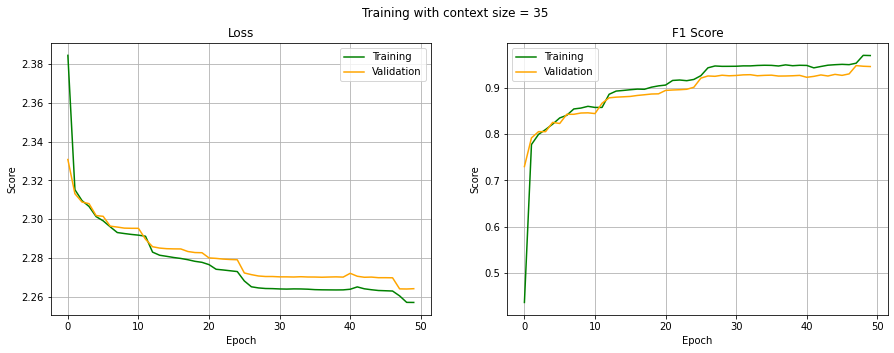

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9693, device='cuda:0'),
 tensor(0.9462, device='cuda:0'),
 tensor(0.9486, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9693, device='cuda:0'),
 tensor(0.9462, device='cuda:0'),
 tensor(0.9486, device='cuda:0'))

## Heatmap

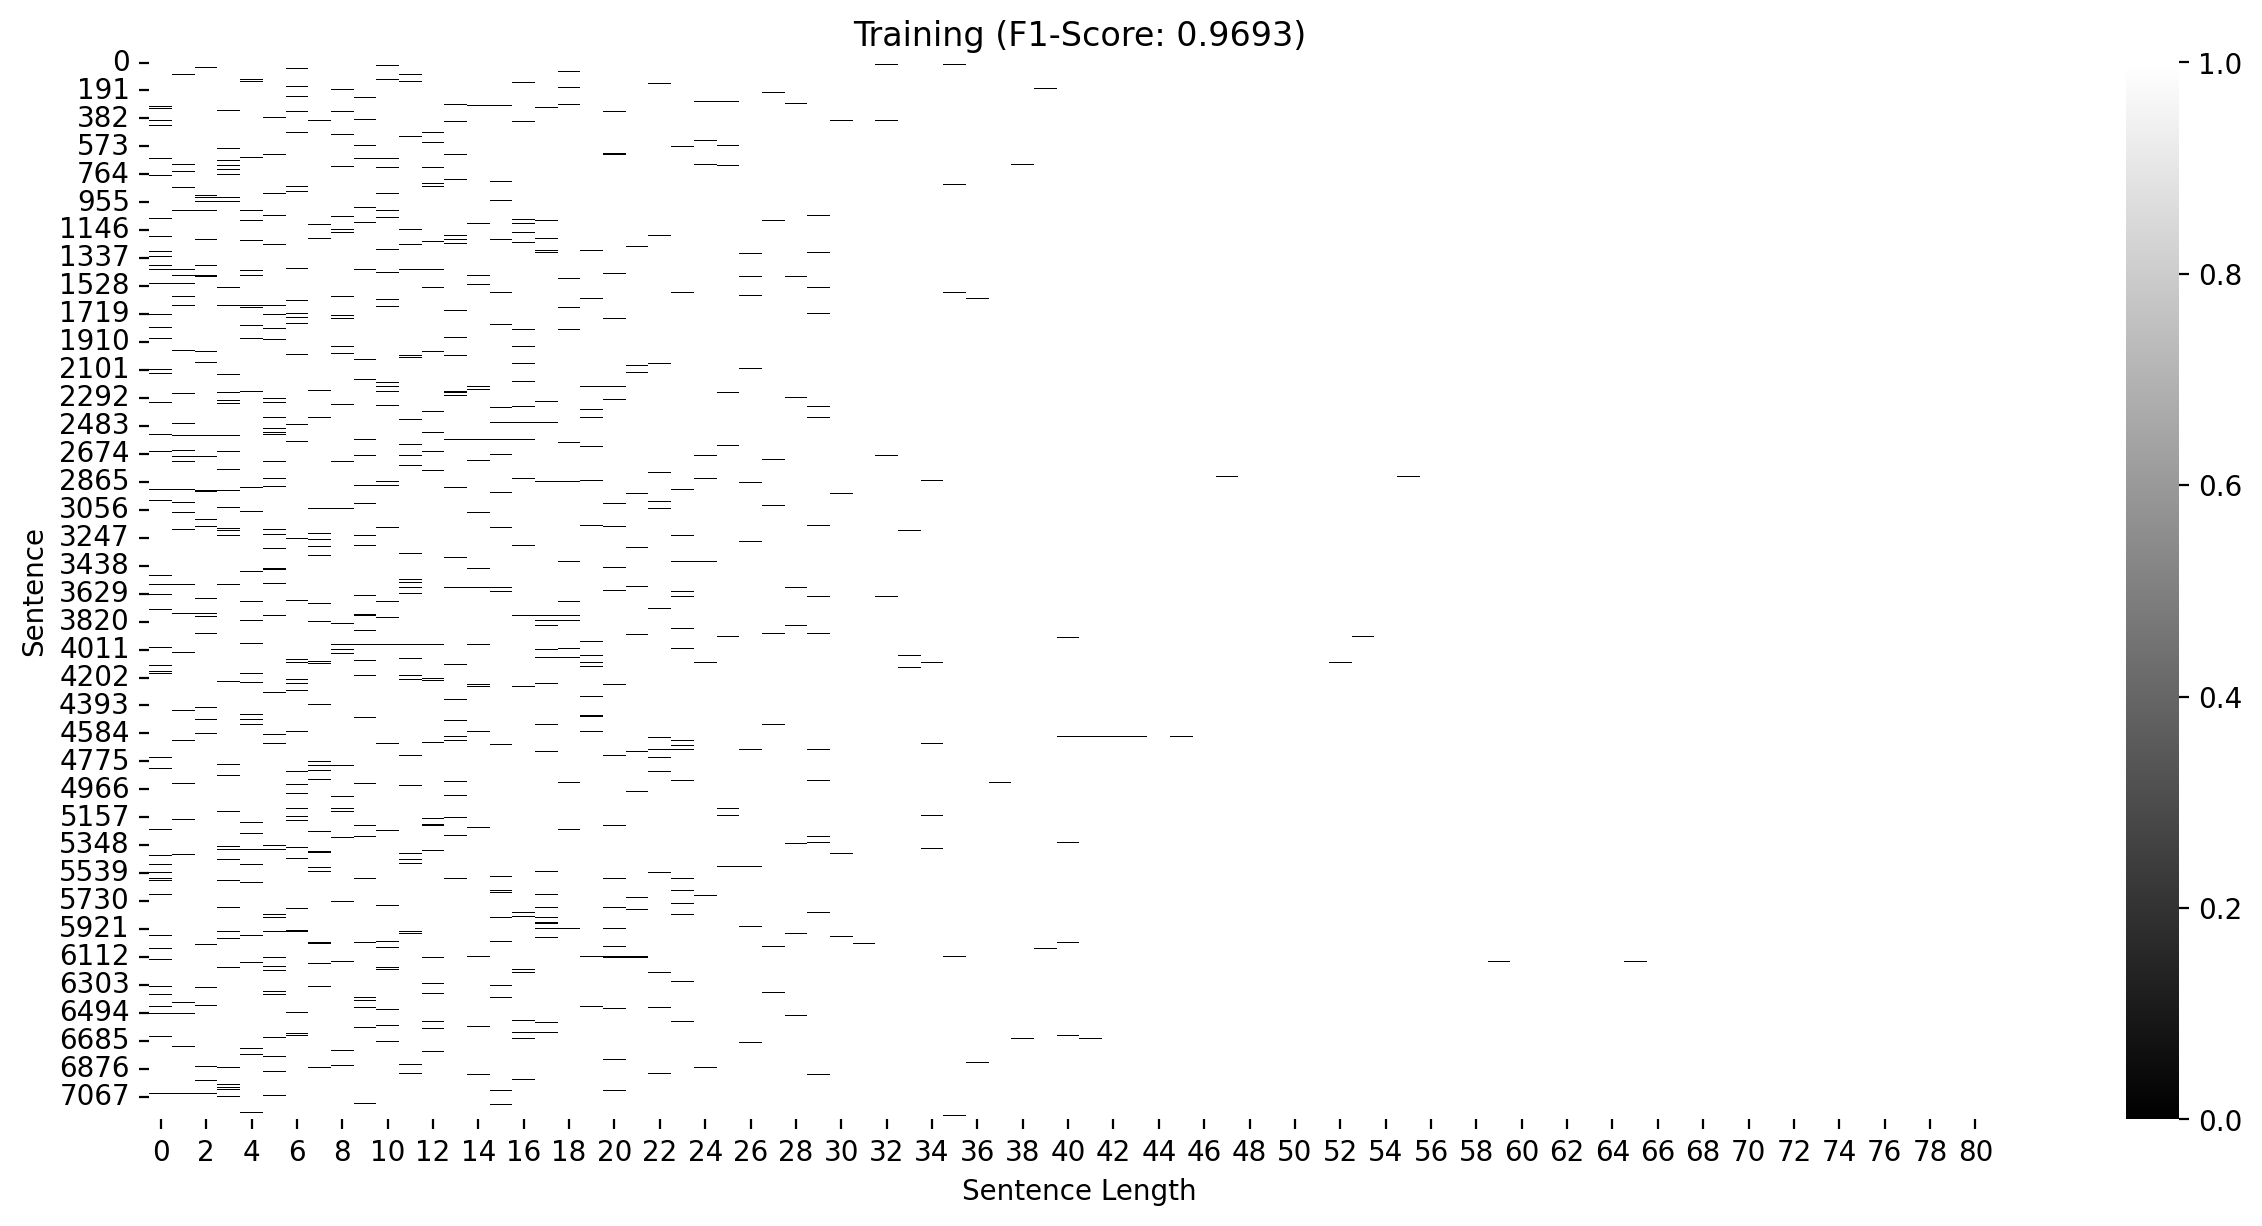

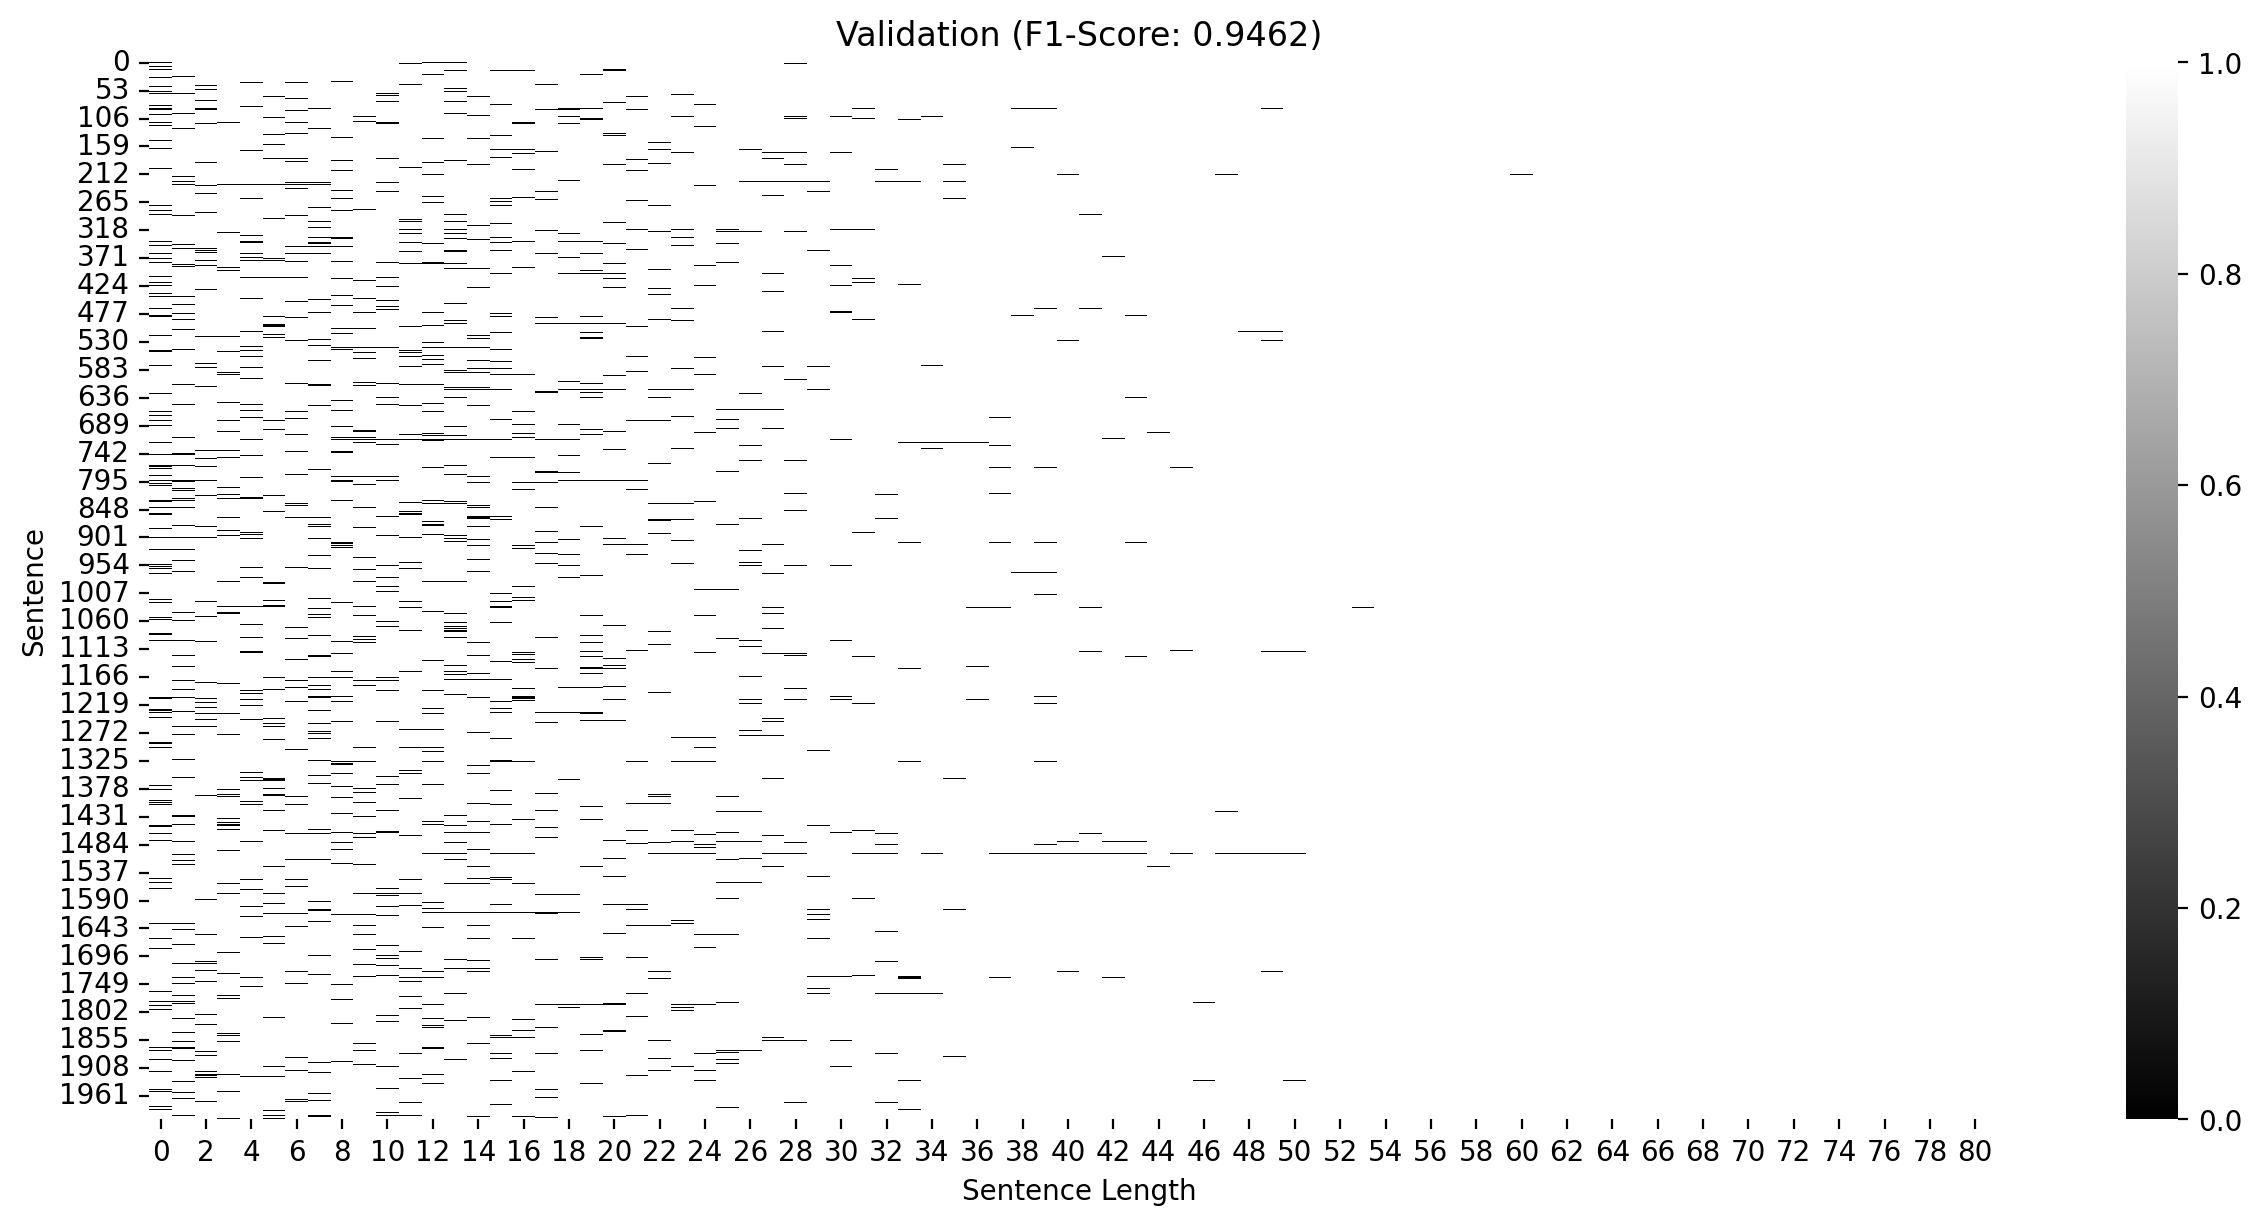

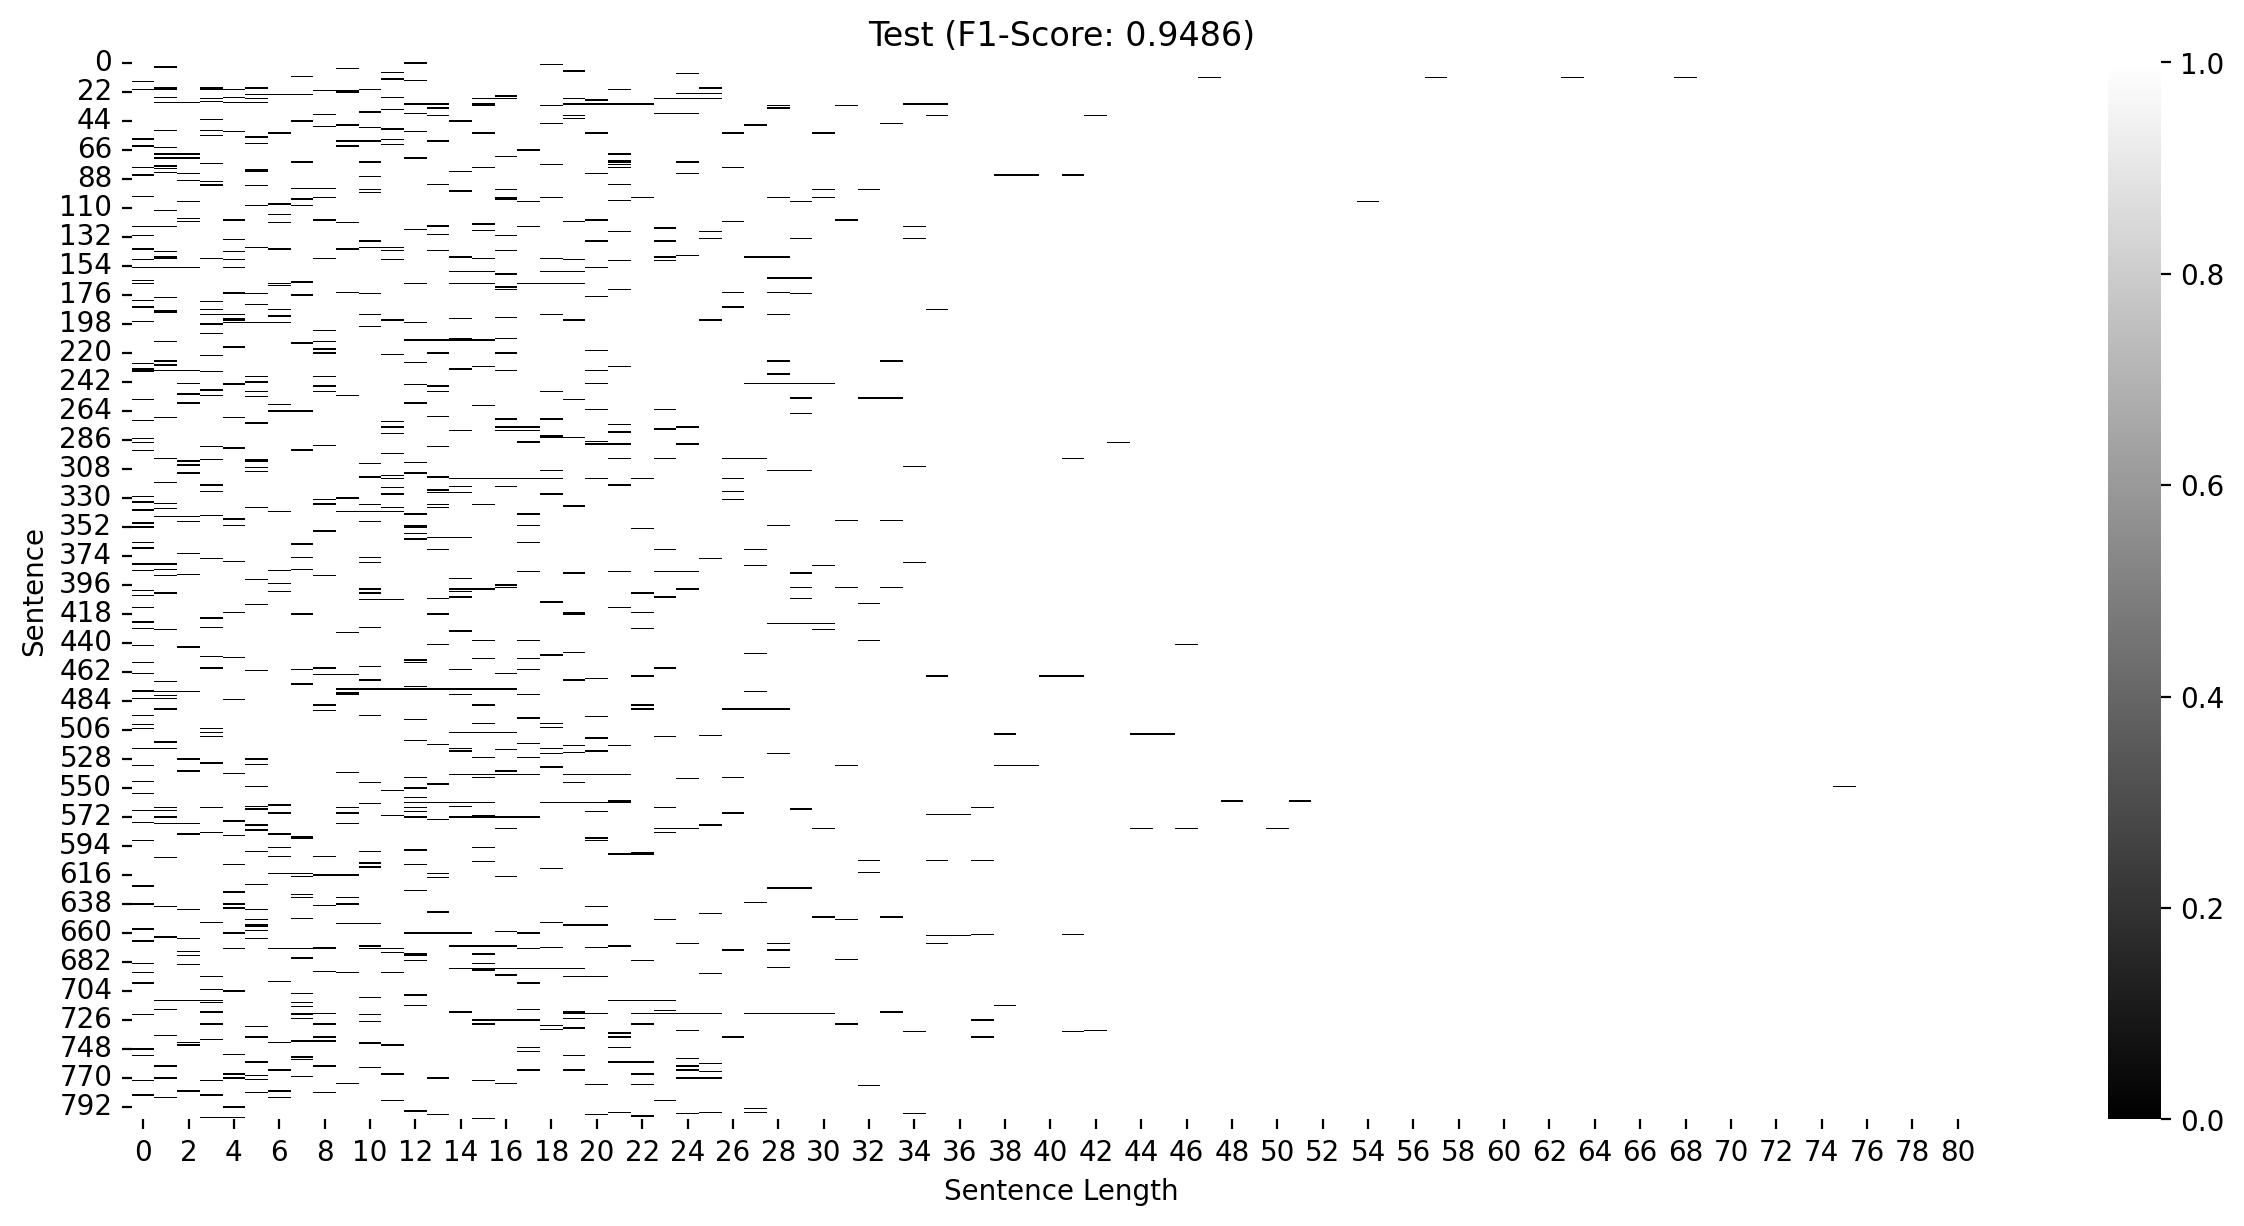

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


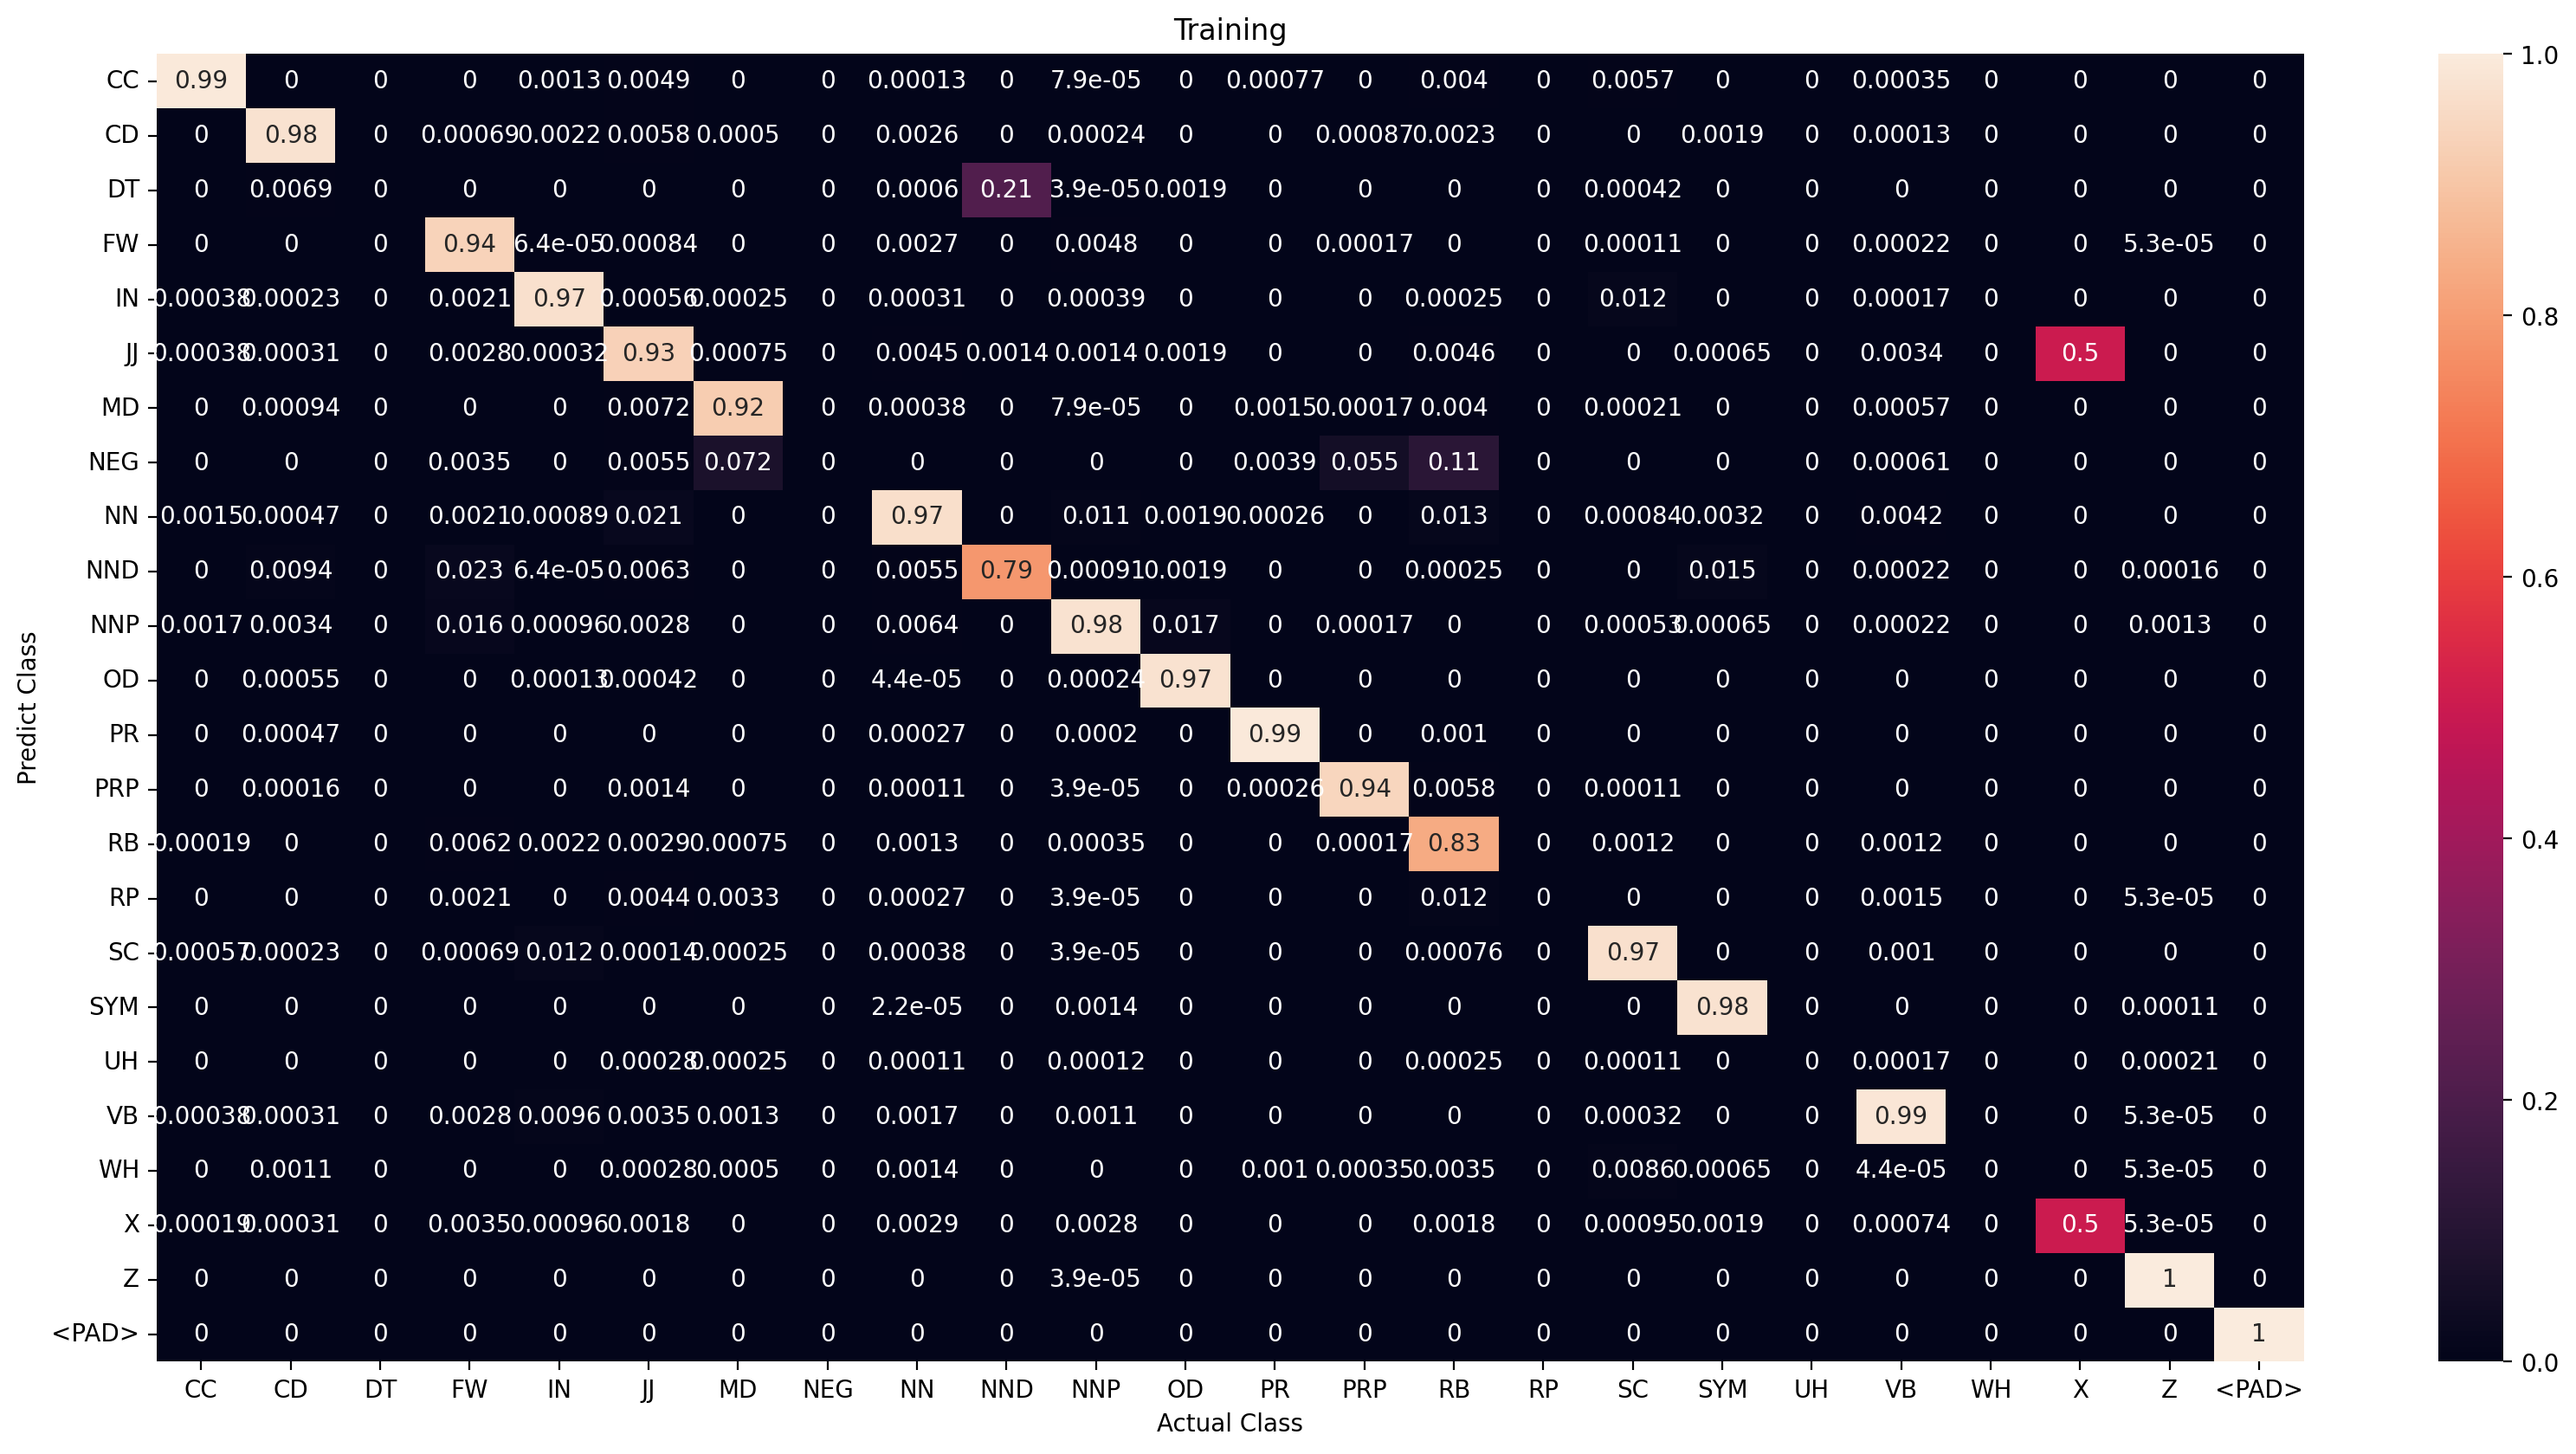

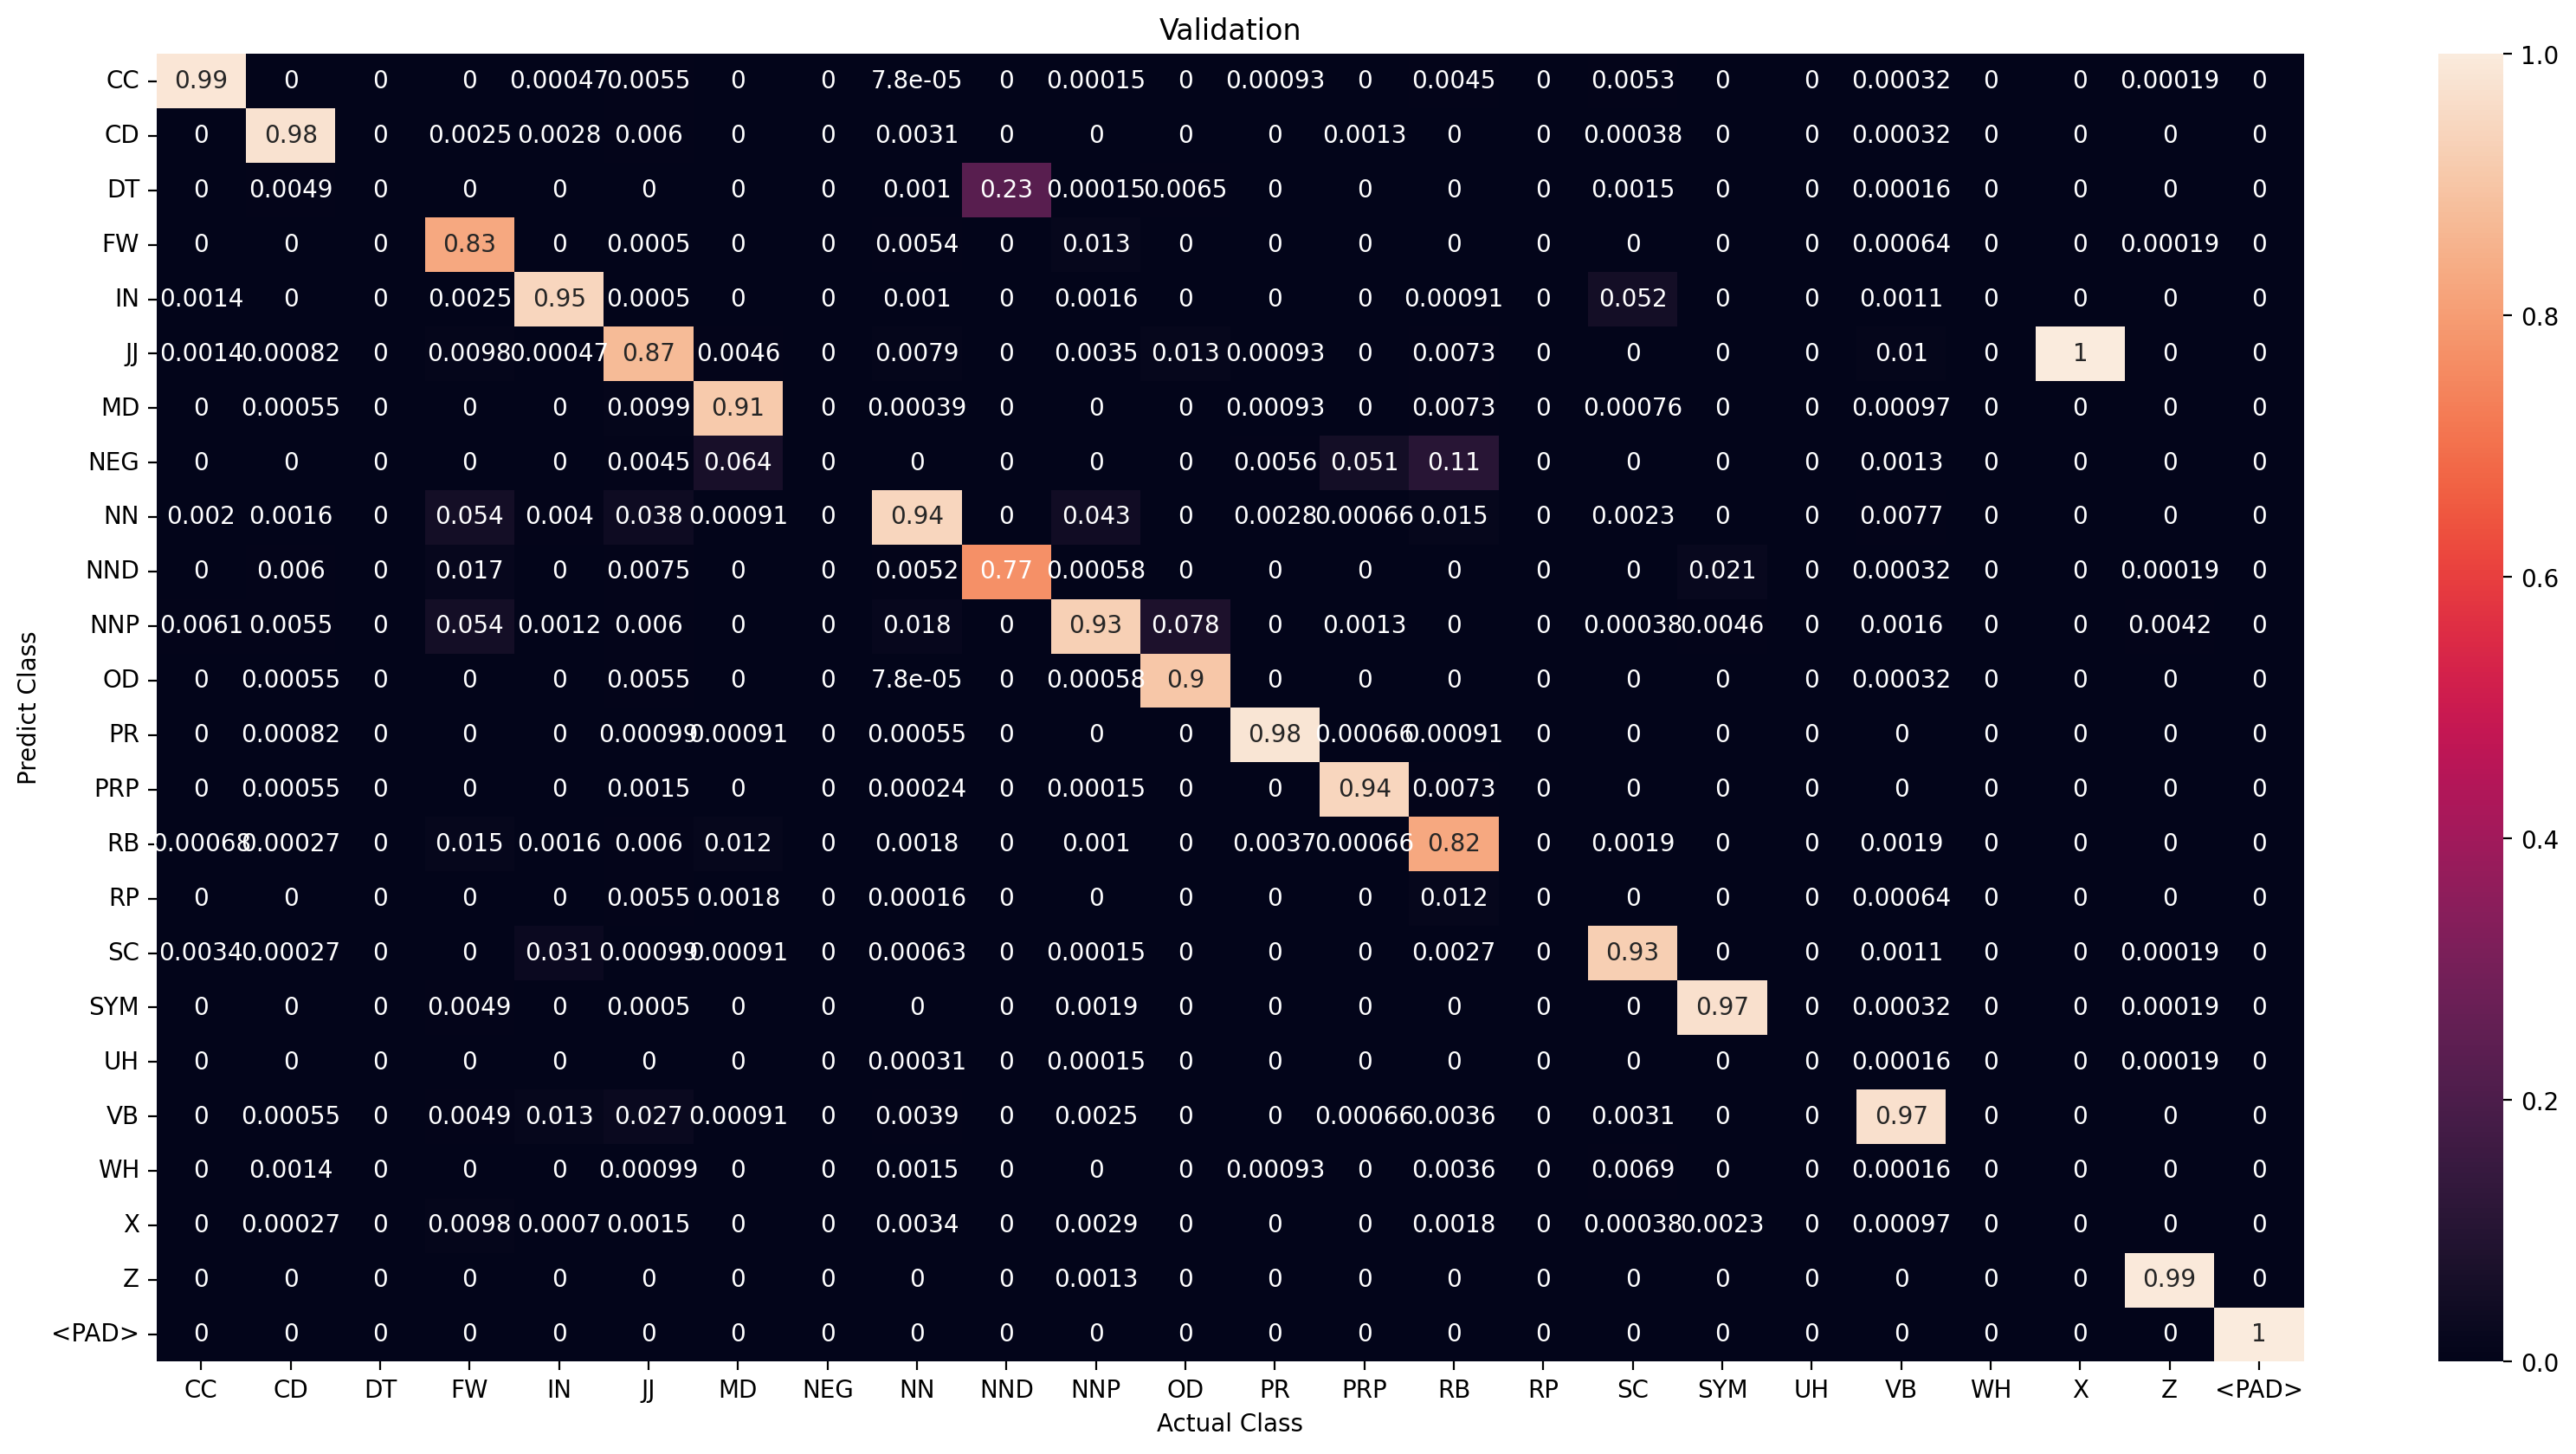

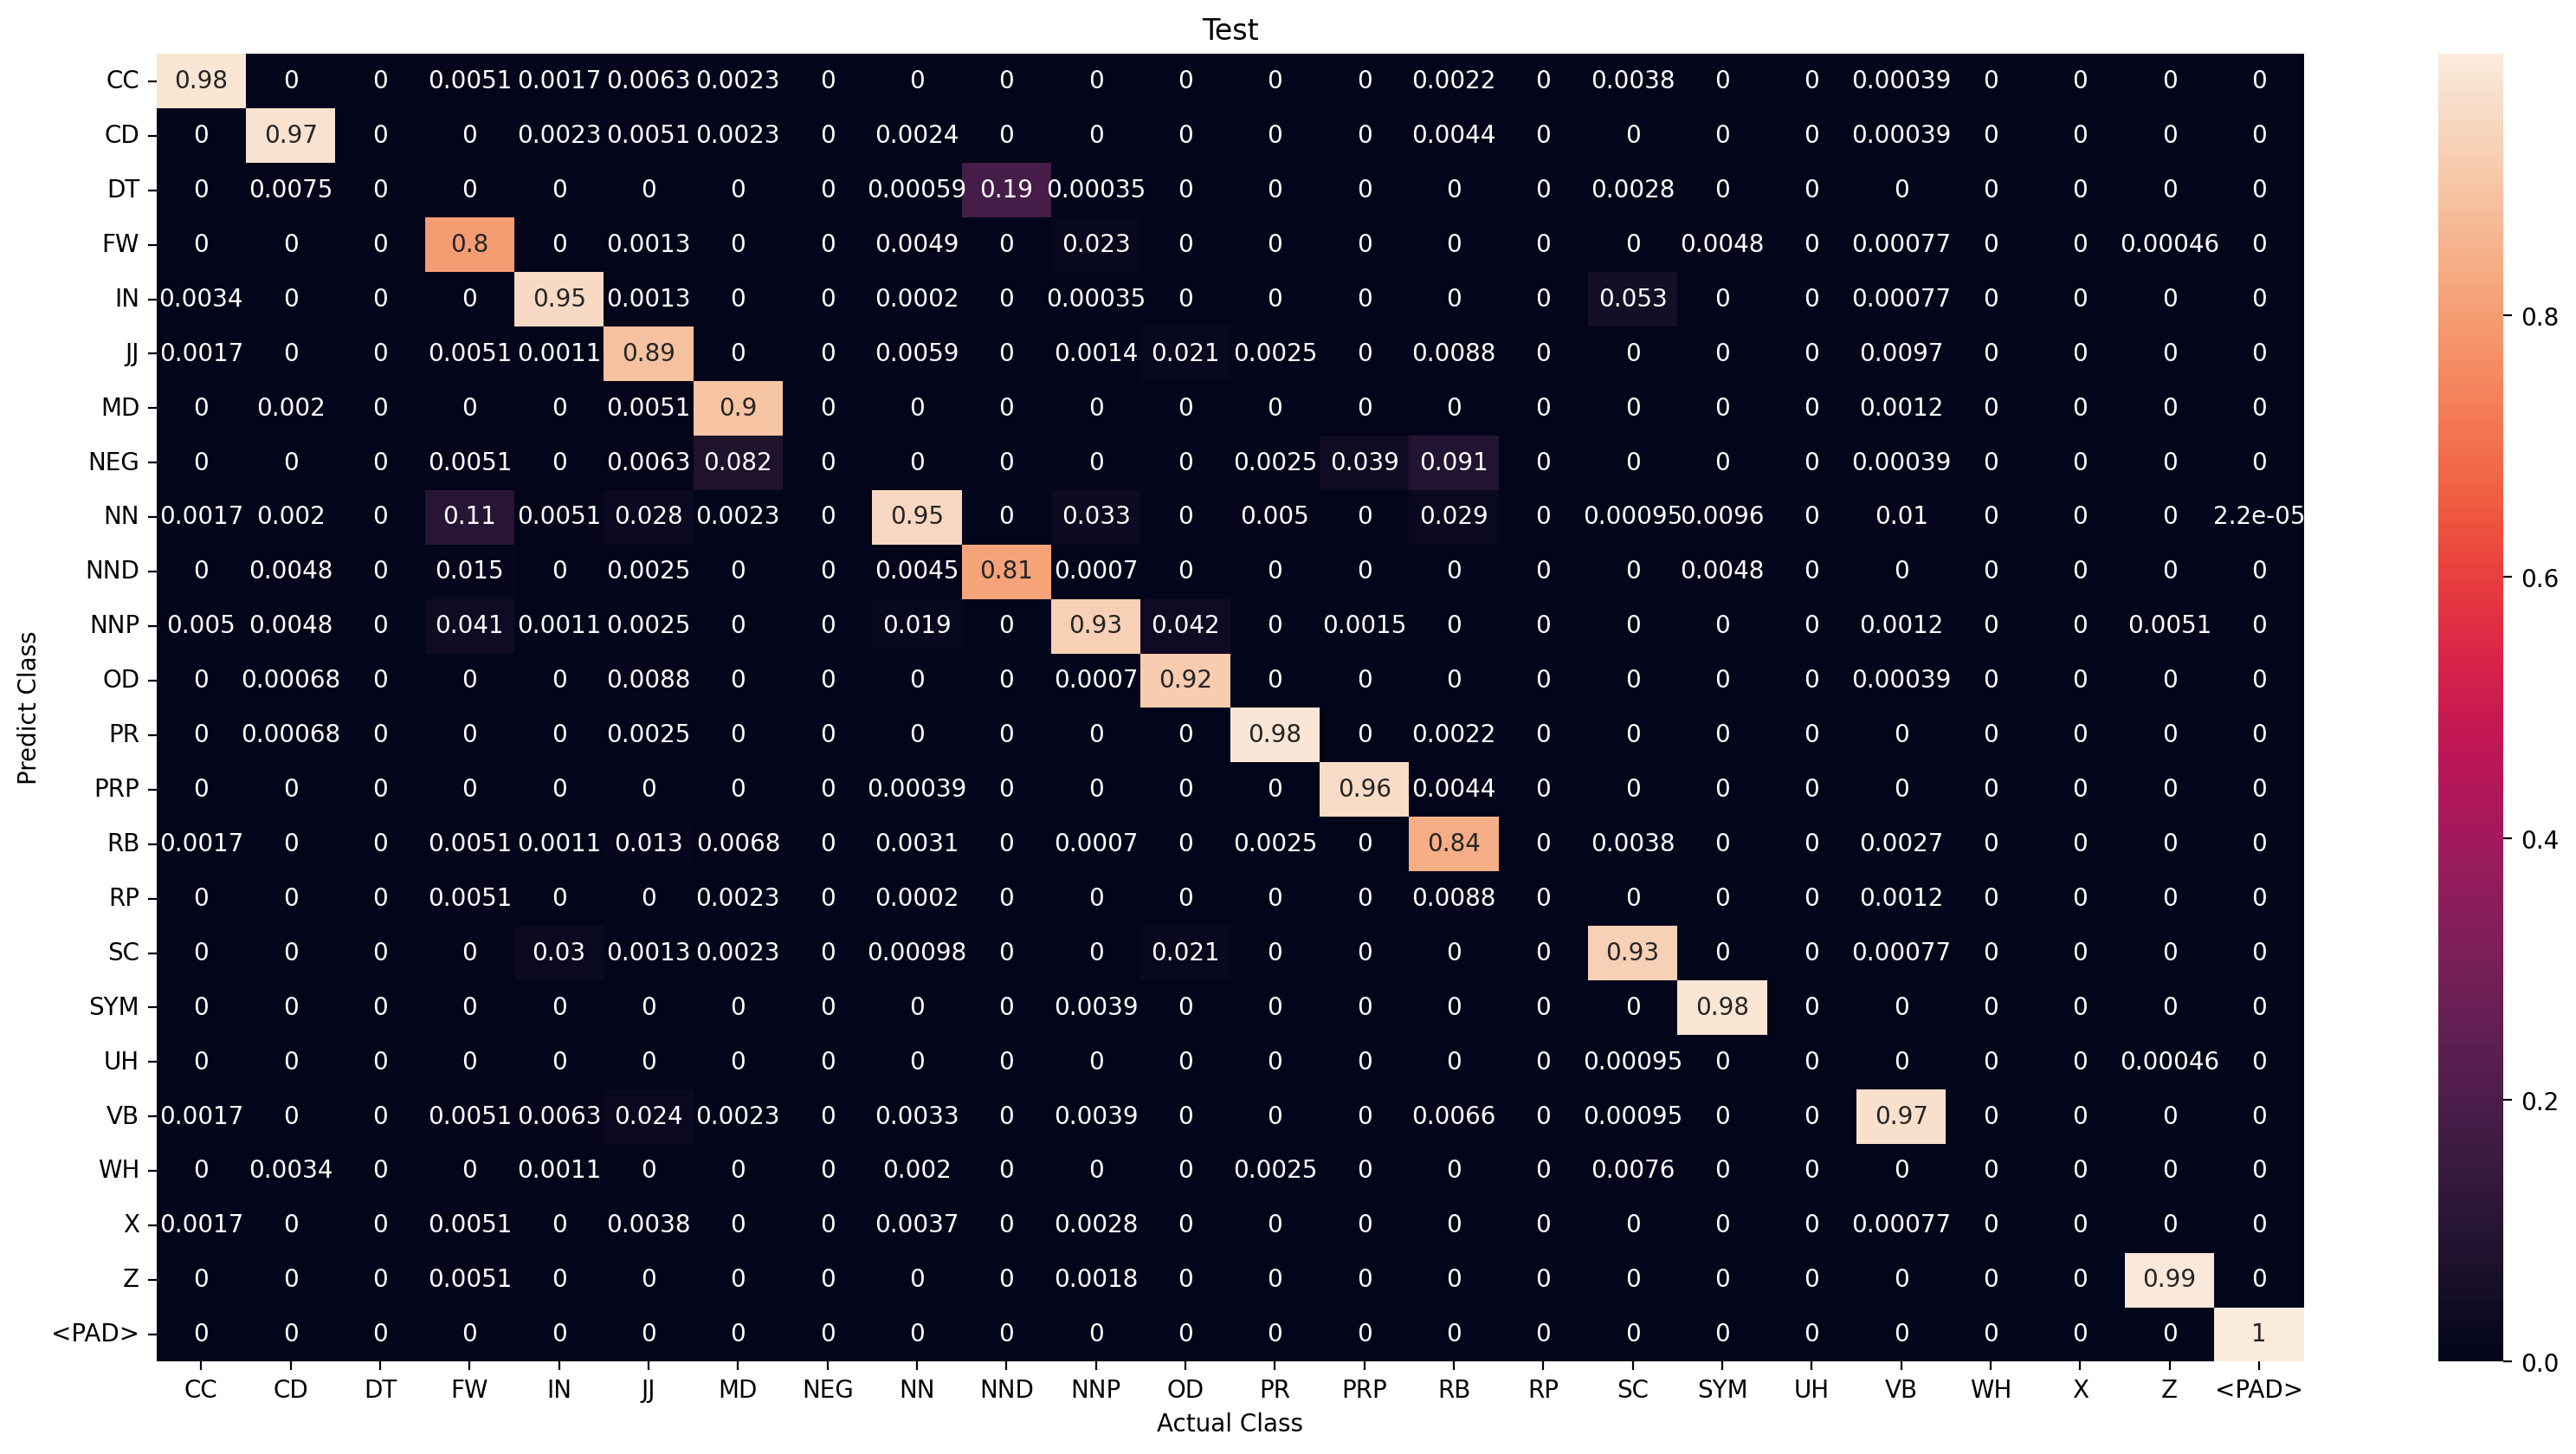

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5202       | CC    : 144      |
| CD    : 12730  | CD    : 12510      | CD    : 220      |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1355       | FW    : 259      |
| IN    : 15342  | IN    : 15188      | IN    : 154      |
| JJ    : 6981   | JJ    : 6624       | JJ    : 357      |
| MD    : 3799   | MD    : 3679       | MD    : 120      |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43756      | NN    : 613      |
| NND   : 1047   | NND   : 545        | NND   : 502      |
| NNP   : 25175  | NNP   : 24730      | NNP   : 445      |
| OD    : 524    | OD    : 504        | OD    : 20       |
| PR    : 3880   | PR    : 3853       | PR    : 27       |
| PRP   : 5471   | PRP   : 5428       | PRP   : 43       |
| RB    : 3477   | RB    : 3302       | RB    : 175      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8, 19, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11093
Wrong prediction            : 713
Percentage correct oov pred : 93.96069795019481

Validation
Number OOV token            : 3366
Correct prediction          : 2957
Wrong prediction            : 409
Percentage correct oov pred : 87.84907902554961

Test
Number OOV token            : 1390
Correct prediction          : 1230
Wrong prediction            : 160
Percentage correct oov pred : 88.48920863309353



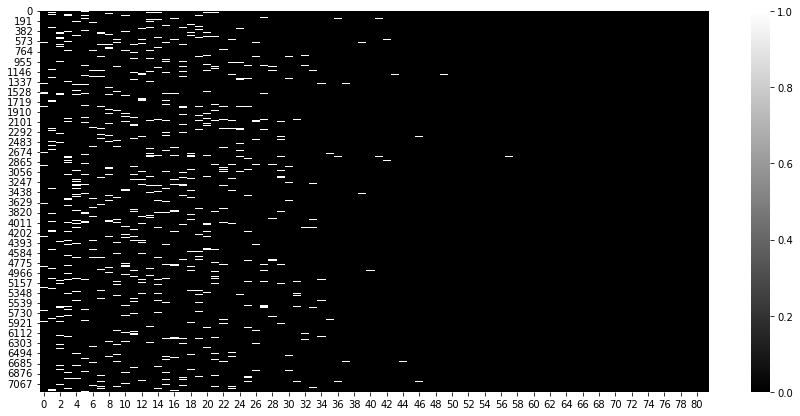

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

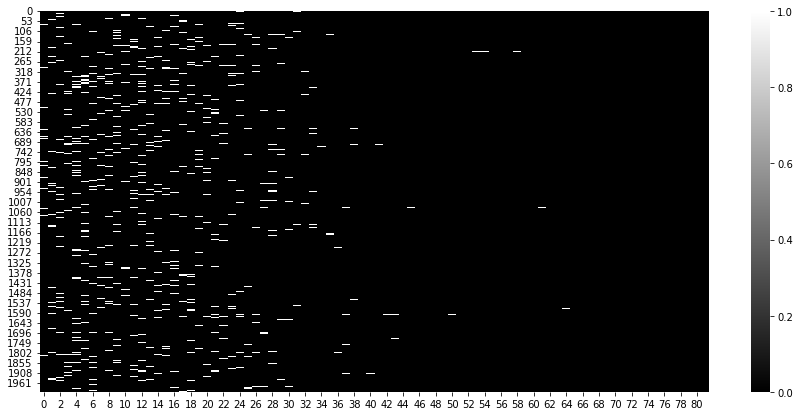

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

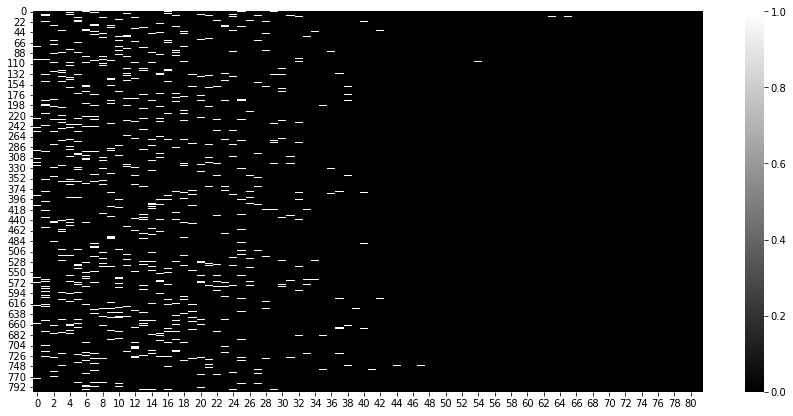

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);